In [1]:
%reload_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions, precondition_functions_v3, precondition_functions_v2
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

In [3]:
jax.devices()

[cuda(id=0)]

In [4]:
key = jax.random.PRNGKey(1)

2025-02-26 16:03:58.213397: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
task = get_task("simple1dstationary")
prior = task.get_prior()
simulator = task.get_simulator()

In [6]:
data = task.get_data(key, 100_000, 2)

In [7]:
sde, weight_fn = init_sde(data, name="VPSDE")

In [8]:
sde.std(sde.T_min)

Array(0.03865063, dtype=float32, weak_type=True)

In [9]:
key, key_init = jax.random.split(key)

In [10]:
c_in, c_noise, c_out = precondition_functions_v2(sde)
init_fn, score_net = build_score_mlp(2, c_in=c_in, c_noise=c_noise, c_out=c_out)
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn, control_variate=False, control_variate_cutoff=1.)

In [11]:
theta_batch, x_batch = batch_sampler(key_init, 10)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

(10, 1) (10, 2, 1)


In [12]:
params = init_fn(key_init, jnp.ones((10,)), theta_batch, x_batch)

In [13]:
score_net(params, jnp.ones((10,)), theta_batch, x_batch).shape

(10, 1, 1)

In [14]:
loss_fn(params, key,theta_batch, x_batch)

Array(25.069668, dtype=float32)

In [15]:

schedule = optax.cosine_onecycle_schedule (
    100_000, 5e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(100), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [16]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [17]:
for i in range(10):
    l = 0.
    for _ in range(10000):
        key, key_batch = jax.random.split(key)
        theta_batch, x_batch = batch_sampler(key_batch, 1000)
        loss, params, opt_state = update(params, key, opt_state, theta_batch, x_batch)
        l += loss/10000
    print(l)

6.410309
6.3878775
6.3627834
6.3706756
6.39114
6.3624177
6.3528123
6.339631
6.3377337
6.3527875


In [18]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [19]:
score_fn = FNPEScoreFn(score_net, params, sde, prior)
score_fn = UncorrectedScoreFn(score_net, params, sde,prior)
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior, posterior_precission_est_fn=lambda x: 2.0)
score_fn = CorrectedScoreFn(score_net, params, sde, prior)

In [20]:
key = jax.random.PRNGKey(7)
theta_o = prior.sample(key)
num_obs = 3
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[1.0114812]


In [21]:

from markovsbi.sampling.sample import Diffuser
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM

kernel = EulerMaruyama(score_fn)
time_grid = jnp.linspace(sde.T_min, sde.T_max, 500)
sampler = Diffuser(kernel, time_grid, (d,))


In [22]:
traces = jax.vmap(sampler.simulate, in_axes=(0,None))(jax.random.split(key,(100,)), x_o)

(-5.0, 5.0)

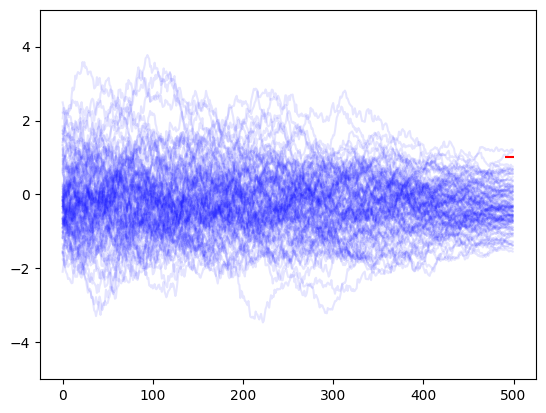

In [23]:
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, 490, 500, color="red")
plt.ylim(-5,5)

In [24]:
import torch
import numpy as np

samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 5000), x_o)

true_posterior = task.get_true_posterior(x_o)
true_samples = true_posterior.sample(jax.random.PRNGKey(1), (5000,))
true_samples = torch.tensor(np.array(true_samples))

/tmp/ipykernel_2498297/2218626153.py:4: UserWarning: offdiag is deprecated, use upper or lower instead.
  pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='dim 1'>)

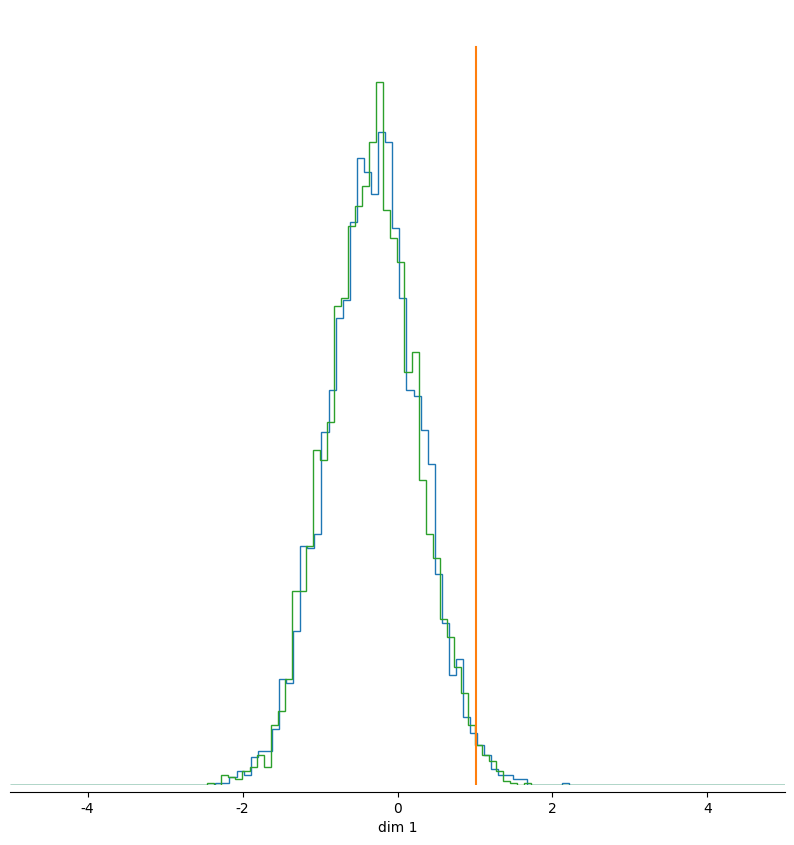

In [25]:
from sbi.analysis import pairplot
import numpy as np
from sympy import limit
pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")

In [ ]:
from sbi.utils.metrics import c2st

c2st(torch.tensor(np.array(samples))[:1000], true_samples[:1000])

tensor(0.4945, dtype=torch.float64)

: 